In [8]:
import os
import warnings
import pprint

import xarray as xr
import numpy as np
import toml
import torch
from scipy.ndimage import gaussian_filter, gaussian_filter1d

import Voodoo.Loader as Loader

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# show quicklook 
%matplotlib inline

warnings.filterwarnings("ignore")

NCLASSES = 3
p = 0.5


In [2]:
data_path = 'example_data/KAZR/nsakazrspeccmaskgecopolC1.a0.20190127.040010.cdf'

data = xr.open_mfdataset(data_path)
data['time'] = data['time_offset'].values + np.timedelta64(4,'h')

In [3]:
hsrl = xr.open_mfdataset('example_data/KAZR/nsahsrlC1.a1.20190127.000000.nc')

#hsrl = hsrl.sel(time=slice(data['time_offset'][0].values, data['time_offset'][-1].values))
backscatter = hsrl['beta_a_backscatter']
depol = hsrl['depol']

In [4]:
# get nonzero mask
nonzeros_mask = data['locator_mask'].values > -1

-98.182816 -45.670033
0.051919557 1.5522848


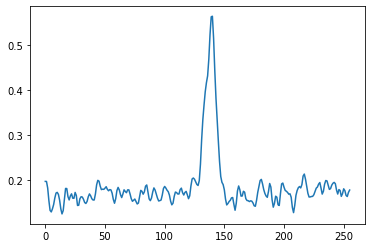

In [5]:
# show spectra quicklook + normalize
spectra_orig = np.flip(data['spectra'].values.copy(), axis=1)
spectra_orig = gaussian_filter1d(spectra_orig, sigma=1)

print(spectra_orig.min(), spectra_orig.max())

# normalize between 0 and 1

v_min = -100
v_max = -65
spectra_norm = (spectra_orig - v_min) / (v_max - v_min)
plt.plot(spectra_norm[1000, :])

print(spectra_norm.min(), spectra_norm.max())

In [6]:
X = np.zeros((spectra_norm.shape)+(6,))
for i in range(spectra_norm.shape[0]):
    for j in range(6):
        X[i, :, j] = spectra_norm[i, :]

In [9]:
prediction = Loader.VoodooPredictor(X)

In [10]:
prediction_smoothed = np.zeros(nonzeros_mask.shape)
_tmp = TM.VoodooNet.reshape(prediction[:, 1], ~nonzeros_mask)
_tmp = gaussian_filter(_tmp, sigma=2)
prediction_smoothed = np.ma.masked_where(~nonzeros_mask, _tmp)
    

In [11]:
# compute fake Z (sum of spectra)
fake_Z = TM.VoodooNet.reshape3d(data['spectra'].values, ~nonzeros_mask)
fake_Z = np.ma.masked_where(~nonzeros_mask, np.sum(10**(fake_Z/10), axis=2)).T
fake_Z = 10*np.log10(fake_Z)
print(fake_Z.min(), fake_Z.max())

-70.221598723326 -34.827239509821595


NameError: name 'UT' is not defined

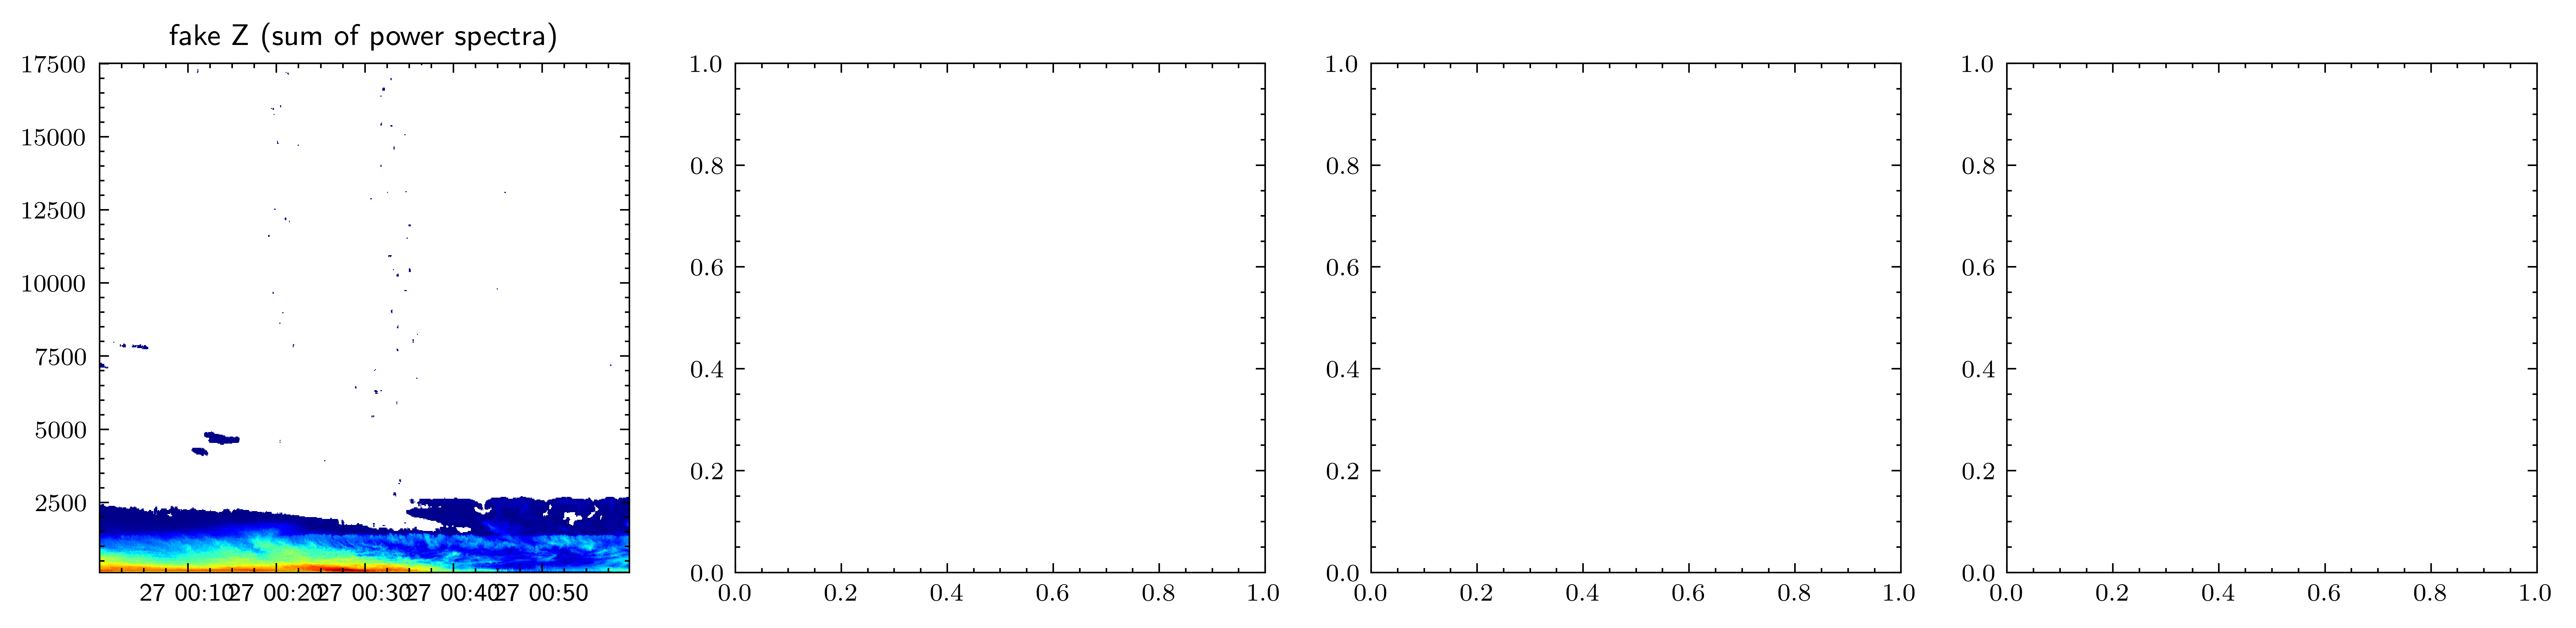

In [12]:

with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots(ncols=4, figsize=(14, 3))

    # fake Z
    pcmesh0 = ax[0].pcolormesh(
        data['time_offset'].values,
        data['range'].values,    
        fake_Z,
        cmap='jet',
        vmin=fake_Z.min(), vmax=fake_Z.max(),
    )
    ax[0].set_title('fake Z (sum of power spectra)')

    # probability for liquid cloud droplets
    pcmesh1 = ax[1].pcolormesh(
        data['time_offset'].values,
        data['range'].values,    
        np.ma.masked_where(~nonzeros_mask, prediction_smoothed).T, 
        cmap=UT.probability_cmap,
        vmin=0.5, vmax=1
    )
    ax[1].set_title('Voodoo output - probabiltiy for cloud droplets')

    # hsrl backscatter
    pcmesh2 = ax[2].pcolormesh(
        backscatter['time'].values,
        backscatter['range'].values,    
        np.log10(backscatter.values).T, 
        cmap='jet', 
        #vmin=0.9, vmax=1
    )
    ax[2].set_title('HSRL backscatter coef.')

    # hsrl depol
    pcmesh3 = ax[3].pcolormesh(
        depol['time'].values,
        depol['range'].values,    
        depol.values.T, 
        cmap='jet', 
        vmin=0., vmax=0.2
    )
    ax[3].set_title('HSRL depol')

    for iax, pcmesh in zip(ax, [pcmesh0, pcmesh1, pcmesh2, pcmesh3]):
        cbar = fig.colorbar(pcmesh, ax=iax, fraction=0.05, orientation='horizontal', pad=0.15)    
        iax.set_ylim([0, 3500])
        iax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    for iax in ax[2:]:    
        iax.set_xlim([data['time'][0].values, data['time'][-1].values])

    fig.savefig('test.png', facecolor='white')